In [27]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import hstack 
import math as mt
import random

from numpy.random import normal 

from matplotlib import pyplot 
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

Mixture of Gaussians algorithm
================================

The following functions are for calculating the E and M step of the Mixture of Gaussians Algorithm. These functions work for binary problems and any number of features and samples. The functions are called by a final function `solve` which returns the vector $\vec{\mu}_1$, $\vec{\mu}_2$ and the covariance matrices $\Sigma_1$ and $\Sigma_2$

In [28]:

def get_gaus(features,samples,sigma,mu,x):
    ''' 
    Necesitamos una Gaussiana para cada clase
    Esta gausiana contiene la matriz Xk con r features
    Es necesario llamar la función para cada Xk perteneciente a la clase k
    '''
    gausiana=np.zeros(samples)
    det_s=np.linalg.det(sigma)
    inv_s=np.linalg.inv(sigma)

    for i in range(samples):
        gausiana[i]=np.exp(-0.5*np.transpose(x[i,:]-mu)@inv_s@(x[i,:]-mu))*1/(np.sqrt((2*mt.pi)**features*det_s))
    return gausiana

def p_get_init(clases,label,train_labels):
    prob=np.zero(clases)
    contador=0
    for k in range(clases):
        if train_labels==label:
            contador=+1
        prob[k]=contador/len(train_labels)
        contador=0
    return  prob


def denominador_gama(p,features,samples,sigma1,sigma2,mu1,mu2,x1,x2):
    ''' 
    sum_k(pi_k*N_k) es la misma para todos, sumamos sobre todas las clases
    '''
    x=np.vstack((x1,x2))
    gausiana1=get_gaus(features,samples,sigma1,mu1,x)
    gausiana2=get_gaus(features,samples,sigma2,mu2,x)
    
    denominador=p[0]*gausiana1+p[1]*gausiana2
    
    return denominador
def get_gama(features,samples,p,gausiana,denominador):
    ''' 
    Necesitamos una gama para cada clase
    Gamma va a ser una matriz
    '''
    gama=np.zeros(samples)
    
    for i in range(samples):
        gama[i]=p*gausiana[i]/denominador[i]


    return gama

def get_nk(gama):
    ''' 
    Nk debe ser calculado para cada clase
    '''
    Nk=np.sum(gama)    
    return Nk

def get_mu(features,gama,x,Nk):
    ''' 
    Vamos a obtener el vector de mus para cada clase
    '''
    mu=np.zeros(features)
    for j in range(features):
        mu[j]=np.sum(gama*x[:,j])/Nk
    return mu

def cov(x0,y0,mu1,mu2,gama,Nk):
    #covr=np.sum(gama*np.transpose(x0-mu[0])@(y0-mu[1]))/Nk
    covr=np.sum(gama*(x0-mu1)@(y0-mu2))/Nk
    return covr
def get_sigma(samples,features,gama,x,Nk,mu):
    ''' 
    Obtenemos la sigma para cada clase
    Sigma es una matriz de features*features
    '''
    #X=np.zeros(samples)
    sigma=np.zeros((features,features))
    
    
    for i in range(samples):
        
        x[i,:]=np.reshape(x[i,:],(1,2))
        mu=np.reshape(mu,(1,2))
        sigma_i=(1/Nk)*gama[i]*np.transpose(x[i,:]-mu)@(x[i,:]-mu)
        sigma=sigma+sigma_i
    

    #for jy in range(features):
        #for jx in range(features):
            #sigma[jx,jy]=np.sum(gama*(x[:,jy]-mu[jy])@np.transpose(x[:,jx]-mu[jx]))/Nk
    #sigma=np.array([[cov(xx, xx,mu[0],mu[0],gama,Nk), cov(xx, xy,mu[0],mu[1],gama,Nk)], \
     #               [cov(xy, xx,mu[1],mu[0],gama,Nk), cov(xy, xy,mu[1],mu[1],gama,Nk)]])
    
    
    return sigma                    
def get_pi(clases,sample1,sample2,Nk1,Nk2):
    samples=sample1+sample2
    p=np.zeros(clases)    
    p[0]=Nk1/samples
    p[1]=Nk2/samples
    return p

def solve(clases,features,samples1,samples2,p,mu1,mu2,sigma1,sigma2,x1,x2):
    #p_ge_init(clases,label,train_labels)
    
    
    contador=0
    #while any(ep)>any(np.array([0.001,0.001] )):
    max_step=5
    for i in range(max_step):
        contador+=1
        print(contador)
        old1=mu1
        old2=mu2

        gausiana1=get_gaus(features,samples1,sigma1,mu1,x1)
        gausiana2=get_gaus(features,samples2,sigma2,mu2,x2)
        samples=samples1+samples2
        denominador=denominador_gama(p,features,samples,sigma1,sigma2,mu1,mu2,x1,x2)
        p1=p[0]
        p2=p[1]
        

        gama1=get_gama(features,samples1,p1,gausiana1,denominador[:samples1])
        gama2=get_gama(features,samples2,p2,gausiana2,denominador[samples1:])
        
        Nk1=get_nk(gama1)
        Nk2=get_nk(gama2)
        print('estos son los nk', Nk1,Nk2)

        mu1=get_mu(features,gama1,x1,Nk1)
        mu2=get_mu(features,gama2,x2,Nk2)

        sigma1=get_sigma(samples1,features,gama1,x1,Nk1,mu1)
        sigma2=get_sigma(samples2,features,gama2,x2,Nk2,mu2)
        
        samples=samples1+samples2
        p=get_pi(clases,samples1,samples2,Nk1,Nk2)
        ep1=np.linalg.norm(mu1-old1)
        ep2=np.linalg.norm(mu2-old2)
        print(mu1,sigma1,mu2,sigma2,p)
        if ep1<0.01 and ep2<0.01:
            break
        
    return mu1,sigma1,mu2,sigma2,p,Nk1,Nk2



In [29]:
x11 = np.random.normal(loc=.3,scale=0.04,size=(800,2))
x12 = np.random.normal(loc=.45,scale=0.05,size=(400,2))
#X1[:,0]=X1[:,0]/np.max(X1[:,0])
#X1[:,1]=X1[:,1]/np.max(X1[:,1])
#X2[:,0]=X2[:,0]/np.max(X2[:,0])
#X2[:,1]=X2[:,1]/np.max(X2[:,1])




clases=int(2)
features=int(2)
samples1=int(800)
samples2=int(400)
p=np.array([0.5,0.5])
mu1=np.array([.1,.2])
mu2=np.array([0.3,0.4])
sigma1=np.identity(2)
sigma2=np.identity(2)
#sigma1=([0.1,0.2],[0.3,0.4])
#sigma2=([0.4,0.5],[0.6,0.8])
mu1,sigma1,mu2,sigma2,p,Nk1,Nk2=solve(clases,features,samples1,samples2,p,mu1,mu2,sigma1,sigma2,x11,x12)
print(Nk1,Nk2)



1
estos son los nk 396.00393043408593 208.01858793466755
[0.29992952 0.29964916] [[1.69297230e-03 4.21095420e-05]
 [4.21095420e-05 1.48783798e-03]] [0.44956961 0.45202872] [[ 2.27433088e-03 -6.07882840e-05]
 [-6.07882840e-05  2.38752788e-03]] [0.33000328 0.17334882]
2
estos son los nk 793.5495083694033 393.59981966286983
[0.29940129 0.29929876] [[1.63602532e-03 3.38335158e-06]
 [3.38335158e-06 1.45765973e-03]] [0.450408   0.45322442] [[ 0.00222168 -0.00014094]
 [-0.00014094  0.00228399]] [0.66129126 0.32799985]
793.5495083694033 393.59981966286983


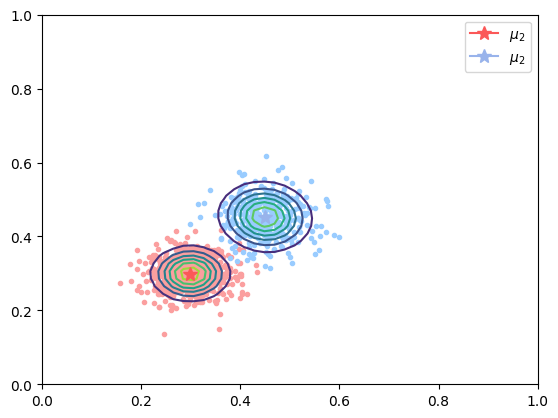

In [30]:
mu_gaussian_1=mu1 
mu_gaussian_2=mu2 
sigma_gaussian_1=sigma1 
sigma_gaussian_2=sigma2 
plt.figure(1) 
# Plotting first Gaussian 
m = np.array(mu_gaussian_1)  # defining the mean of the Gaussian  
cov = np.array(sigma_gaussian_1)   # defining the covariance matrix 
cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix 
cov_det = np.linalg.det(cov)  # determinant of covariance matrix 
x = np.linspace(0, 1) # defining the x axis from 0 to 1 (because we have normalized the data) 
y = np.linspace(0, 1) 
X,Y = np.meshgrid(x,y) 
coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5 
Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2)) 
plt.contour(X,Y,Z) 

# Plotting second Gaussian 
m = np.array(mu_gaussian_2)  # defining the mean of the Gaussian (mX = 0.2, mY=0.6) 
cov = np.array(sigma_gaussian_2)   # defining the covariance matrix 
cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix 
cov_det = np.linalg.det(cov)  # determinant of covariance matrix  
x = np.linspace(0, 1) 
y = np.linspace(0, 1) 
X,Y = np.meshgrid(x,y) 
coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5 
Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2)) 
plt.contour(X,Y,Z) 

 
 
 

#-----plot of the samples---------------- 





plt.scatter(x11[:,0], x11[:,1],color='#fb9f9f',marker='.')
plt.scatter(x12[:,0], x12[:,1], color='#99ccff',marker='.') 
plt.plot(mu1[0],mu1[1],color='#fb5858',marker='*',markersize=10,label=r'$\mu_2$')
plt.plot(mu2[0],mu2[1],color='#98B3EB',marker='*',markersize=10,label=r'$\mu_2$')
plt.legend()
 
 
 

plt.show() 

In [31]:
data = pd.read_csv ('final.csv')   
df = pd.DataFrame(data)

cols=list(df)
print(cols)
X=df[df.columns[2:]].to_numpy()
y=df[df.columns[1]].to_numpy()
y=y.astype(int)
#y=y[:500]
#X=X[:500]
for i in range(len(y)):
    if y[i]==-1:
        y[i]=0

X_train, X_test, y_train, y_test=train_test_split(
    X,y, test_size=1/3, random_state=1, shuffle=True, stratify=None)
X_test, X_v, y_test, y_v=train_test_split(
    X_test,y_test, test_size=1/3, random_state=1, shuffle=True, stratify=None)

'''
X_train=jax.numpy.asarray(X_train)
X_test=jax.numpy.asarray(X_test)
X_v=jax.numpy.asarray(X_v)
y_train=jax.numpy.asarray(y_train)
y_test=jax.numpy.asarray(y_test)
y_v=jax.numpy.asarray(y_v)
'''



['Unnamed: 0', 'class', 'age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', '1', 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', 'Prof-school', '7th-8th', 'Bachelors', 'Masters', '5th-6th', 'Assoc-voc', '9th', 'Doctorate', '12th', '1st-4th', 'Preschool', 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse', 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv', 'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical', 'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces', 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative', 'Black', 'White', 'Other', 'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Male', 'Female', 'United-States', 'Peru', 'Guatemala', 'Mexico', 'Dominican-Republic', 'Irel

'\nX_train=jax.numpy.asarray(X_train)\nX_test=jax.numpy.asarray(X_test)\nX_v=jax.numpy.asarray(X_v)\ny_train=jax.numpy.asarray(y_train)\ny_test=jax.numpy.asarray(y_test)\ny_v=jax.numpy.asarray(y_v)\n'

In [32]:
print(X_v.shape)

(5025, 104)


Ejercicio 3. Feature selection:
==================================

We apply Sequential Backward Selection

In [33]:
import itertools
from itertools import combinations
import random


#first,we bring our data from the previously cleaned dataset
df_x=pd.DataFrame(X_train) 
df_y=pd.DataFrame(y_train, columns=['y']) 
df=pd.concat([df_x, df_y], axis=1) 
df1_X_class_1= df[df['y'] ==0 ] 
df1_X_class_1 = df1_X_class_1.drop(df1_X_class_1.columns[-1],axis=1) 
df1_X_class_2= df[df['y'] ==1 ] 
df1_X_class_1 = df1_X_class_1.drop(df1_X_class_1.columns[-1],axis=1) 
#reconvert to numpy array 
X_class_1=df1_X_class_1.to_numpy() 
X_class_2=df1_X_class_2.to_numpy() 
print(X_class_2.shape)

#we have too many features, it will be to much for the sequential backwards selection
#then, we need to use the following function to separate the data in random groups and select the best
#the best group is selected in base to the maximum norm of the mean
def group_mus(X_class_1,X_class_2,num_features,num_grupos,size_grupos):
    ''' 
    This function takes the total of features and selects a random group of features with the maximum norm between them
    args:
        X_class1: Data array of n samples x m features belonging to class 1
        X_class2: Data array of n samples x m features belonging to class 1
        num_features: integer, number of features
        num_grupos: number of groups in which we want to divide the total of features
        size_grupos: number of features in each group
    
    return:
        x1_ganadores: array of size (samples, winning features)
        x2_ganadores: array of size (samples, winning features)
        ganadores: indexes, (taken from the original array) of the winning features

    '''
    lista_index=random.sample(list(range(0,num_features)),num_features) #desordenamos los números del 0 al num_features
    list_mu=[]

    mu1=np.zeros(size_grupos) #in this vector we'll save the components of the average for each feature in class 1
    mu2=np.zeros(size_grupos) #in this vector we'll save the components of the average for each feature in class 2
    r=0
    for i in range(num_grupos):
        
        j=lista_index[i+r] #the column number is taken from our desorderd list 'lista_index'
        for k in range(size_grupos):
            if j==103:
             j=100
            mu1[k]=np.mean(X_class_1[:,j]) 
            mu2[k]=np.mean(X_class_2[:,j])
        mu_resta=np.linalg.norm(mu1-mu2) #we take the norm of the substraction of averages in each class
        list_mu.append(mu_resta)
        
        
        r=r+size_grupos #for i=0, we take the first num_grupos from 'lista_index', for i=1 the next group, etc
    #print('lista mus',list_mu)
    ganador=np.argmax(mu_resta) #we take the index of the greatest separation between mu1 and mu2
    x1_ganadores=np.zeros((X_class_1.shape[0],size_grupos))
    x2_ganadores=np.zeros((X_class_2.shape[0],size_grupos))
    ganadores=[]
    for i in range(size_grupos):
        index=lista_index[size_grupos*ganador+i]
        if index==103:
            index=100
        x1_ganadores[:,i]=X_class_1[:,index]
        x2_ganadores[:,i]=X_class_2[:,index]
        ganadores.append(index)

    return x1_ganadores,x2_ganadores,ganadores
##############################################################################
##########################################################################
####Now we create the function for the SEQUENTIAL BACKWARDS SELECTION#######

  

def sequential_backwards(size,x1,x2,min_group):
    ''' 
    This functions performs a sequential backwards selection

    args:
        size: integer, size of the original input data
        x1: array of data belonging to class 1
        x2: array of data belonging to class 2
        min_group: integer, size of group we want to achieve
    
    return: 
        x1
        x2
        ganadores
        col

    '''

    lista=[]
    for i in range(size):
        lista.append(i)
    for i in reversed(range(min_group,size+1)):
        total=i #mumero de grupos que tenemos
        size_grupos=int(i-1) #miembros de cada grupo
        min_group=min_group+1
        
        index_combinacion=list(combinations(lista,size_grupos)) #lista de tamaño 'total' de sublistas de tamaño 'size_grupos'
        #print(index_combinacion)
        mus=[]
        for j in range(total):
            iter=index_combinacion[j] #iter es una lista de tamaño size_grupos, se trae la sublista j de index_combinations
            
            mu1=np.zeros(size_grupos) 
            mu2=np.zeros(size_grupos)
            mu_r=np.zeros(size_grupos)
            for k in range(size_grupos):
                mu1[k]=np.mean(x1[:,iter[k]])
                mu2[k]=np.mean(x2[:,iter[k]])
                mu_r[k]=mu1[k]-mu2[k]
           
            mu_norm=np.linalg.norm(mu_r)
            mus.append(mu_norm)
        #print('esta es la lista de mus',mus)
        print('la norma maxima fue.',max(mus))
        ganador=np.argmax(mus)
        #print('ganó el grupo',ganador)
        #print('los miembros del grupo ganador son',index_combinacion[ganador])
        #la lista de indices que combinaremos en la sig. iteracion serán los miembros de la sublista ganadora
        lista=index_combinacion[ganador] 
        ganadores=[]
        x1g=np.zeros((x1.shape[0],size_grupos+1))
        x2g=np.zeros((x2.shape[0],size_grupos+1))
        col=[]
        for i in range(size_grupos):
            index=lista[i]#***
            col.append(columnas[index])
            
            ganadores.append(index)
            x1g[:,i]=x1[:,index]
            x2g[:,i]=x2[:,index]
        #print(col)
        x1=x1g
        x2=x2g
    return x1,x2,ganadores,col

####################################################################################
###################################################################################
######And now we call our two functions###########################################

num_grupos=int(8) #we want to divide the initial dataset in 8 groups
size_grupos=int(13) #each group has 13 members
num_features=len(X_train[1]) ##the total number of original features

#and we call our function for dividing our original dataset
x1_ganadores,x2_ganadores,ganadores=group_mus(X_class_1,X_class_2,num_features,num_grupos,size_grupos)
print(x1_ganadores.shape)

columnas=[]
for i in range(len(ganadores)):
    index=ganadores[i]+1
    columnas.append(cols[index])
print('From the first cut, the selected features are:',columnas) 

#now we call our backwards selection function. 
#5 is the input entry of 'min_group', which means that we want to end up with 5-1 final features
size=13
x1,x2,ganadores,col= sequential_backwards(size,x1_ganadores,x2_ganadores,3)  
print('The names of the winning features are:',col)
x1=x1[:,:-1]
x2=x2[:,:-1]


(22715, 105)
(7433, 13)
From the first cut, the selected features are: ['11th', 'Outlying-US', 'Armed-Forces', '1', 'Prof-school', 'Assoc-voc', 'Local-gov', 'Married-AF-spouse', 'Hong', 'Scotland', '1st-4th', 'Asian-Pac-Islander', 'Male']
la norma maxima fue. 0.42579765407652664
la norma maxima fue. 0.4257938907868746
la norma maxima fue. 0.42578842641757264
la norma maxima fue. 0.35519320016056294
la norma maxima fue. 0.2665119787353858
la norma maxima fue. 0.266508966295153
la norma maxima fue. 0.19326483142244125
la norma maxima fue. 0.1505709482158189
la norma maxima fue. 0.14929562194895343
la norma maxima fue. 0.14847206077655736
la norma maxima fue. 0.14742247950355897
The names of the winning features are: ['11th', 'Armed-Forces']


Apply Mixtures of Gaussians
==============================
Now, we use the algorithm  Mixture of Gaussians (which was programmed in excercise 2) on our final selected features

In [34]:
clases=int(2)
features=int(2)
samples1=X_class_1.shape[0]
samples2=X_class_2.shape[0]
p=np.array([0.5,0.5])
mu1=np.array([.666,.66])
mu2=np.array([0.8666,0.8666])
sigma1=np.identity(2)
sigma2=np.identity(2)
print(x2.shape)
print(samples2)
mu1,sigma1,mu2,sigma2,p=solve(clases,features,samples1,samples2,p,mu1,mu2,sigma1,sigma2,x1,x2)


(22715, 2)
22715
1
estos son los nk 4195.779942737726 10104.401866895983
[0.20831554 0.02768526] [[0.16492018 0.01000432]
 [0.01000432 0.02691878]] [0.39161575 0.08730169] [[0.23825285 0.01128496]
 [0.01128496 0.0796801 ]] [0.13917275 0.33515994]
2
estos son los nk 3265.38173298776 14105.984088412728
[1.01084719e-01 2.20328385e-07] [[9.08665990e-02 1.26144921e-07]
 [1.26144921e-07 2.20328336e-07]] [0.47394763 0.1254074 ] [[0.24932127 0.00273544]
 [0.00273544 0.10968038]] [0.10831172 0.46789121]
3
estos son los nk 6966.269050808967 2862.3549543492272
[0.18825915 0.        ] [[0.15281764 0.        ]
 [0.         0.        ]] [0.67735562 0.61802258] [[ 0.21854498 -0.11223   ]
 [-0.11223     0.23607067]] [0.23106903 0.09494344]
4


LinAlgError: Singular matrix

Conclusions
==========

For this data set, it was seen that after reducing the number of features to a group of 13, the maximum distance between $\mu_{1}$ and $\mu_{2}$ of each class was obtained for around 4 features. But running the Mixture of Gaussian algorithm on these features gives a singular matrix around the step 3 or 4, depending on the set of 4 selected features. The same happens for 3 features. This might happen because in this dataset almost all the featuers are one hot. If we run the algorithm only considering the features that are not one hot, the algorithm converges, but this elimination results in a considerable loss of information since only 6/104 features are not one hot.